# Aggregating manual annotations and correlations

We read the evaluation results from excel files that have the following columns:

Turn	
Speaker	
Cue	
Response	
Context

System ratings
* MLM response	
* System llh	
* MLM llh	
* USR DLcontext	
* USR DLfact	

Human ratings:
* Overall Human Rating	
* Interesting	
* Engaging	
* Specific	
* Relevant	
* Correct	
* Semantically Appropriate	
* Understandable	
* Fluent

In [33]:
# Needed to calculate the mean square error for regression scores
#! pip install sklearn

In [34]:
### Needed to read Ecel files: xlsx
# ! pip install openpyxl

In [152]:
def get_score_triples_from_turn(json_row:str, speaker_scores:{}, auto_score:str, hum_score:str):
    speaker = json_row['Speaker']
    turn = json_row['Turn']
    auto = json_row[auto_score]
    hum = json_row[hum_score]
    triple = (turn, auto, hum)
    if not speaker_scores.get(speaker):
        speaker_scores[speaker]=[]
    speaker_scores[speaker].append(triple)
    
def evaluate_regression_scores(basepath:Path, speaker_scores:{},auto_score:str, hum_score:str):
    turn_index =[]
    speaker_scores:{}
    for path in basepath.glob('*.xlsx'):
        df = pd.read_excel(name)
        #print(name)
        js = df.to_json(orient = 'records')
        for turn in json.loads(js):
            get_score_triples_from_turn(turn, speaker_scores, auto_score,hum_score)

def get_scores_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        if not turn_scores.get(turn):
            turn_scores[turn]=[]
        turn_scores[turn].append(score)

def get_score_for_turns(json_row:str, turn_scores:{}, score_name:str):
    turn = json_row['Turn']
    score = json_row[score_name]
    if score:
        turn_scores[turn]= score

def get_normalized_human_scores(basepath:Path, score_name:str):
    normalized_scores = {}
    for path in basepath.glob('*.xlsx'):
        df = pd.read_excel(name)
        #print(name)
        js = df.to_json(orient = 'records')
        turn_scores={}
        for turn in json.loads(js):
            get_scores_for_turns(turn, turn_scores, score_name)
        for turn_id in turn_scores:
            if not all_turn_scores.get(turn_id):
                all_turn_scores[turn_id]=[]
            all_turn_scores[turn_id].extend(turn_scores[turn_id])

    for turn_id in all_turn_scores:
        scores = all_turn_scores[turn_id]
        average = sum(scores)/len(scores)
        normalized_score = (average-1)/4
        normalized_scores[turn_id]=normalized_score
    #print(normalized_scores)
    return normalized_scores

In [139]:
from pathlib import Path
import glob
import pandas as pd
import json
import math
import numpy as np
import matplotlib.pyplot as plt

annotation_path = "/Users/piek/PycharmProjects/cltl-chatbots/annotations"
#annotation_path = "."
basepath = Path(annotation_path)

## Averaging the human annotations 

In [140]:
score_name = "Overall Human Rating"
normalized_scores_overall = get_normalized_human_scores(basepath, score_name)

score_name = "Interesting"
normalized_scores_interesting = get_normalized_human_scores(basepath, score_name)

score_name = "Engaging"
normalized_scores_engaging = get_normalized_human_scores(basepath, score_name)

score_name = "Specific"
normalized_scores_specific = get_normalized_human_scores(basepath, score_name)

score_name = "Relevant"
normalized_scores_relevant = get_normalized_human_scores(basepath, score_name)

score_name = "Correct"
normalized_scores_correct = get_normalized_human_scores(basepath, score_name)

score_name = "Semantically Appropriate"
normalized_scores_semantic = get_normalized_human_scores(basepath, score_name)

score_name = "Understandable"
normalized_scores_understandable = get_normalized_human_scores(basepath, score_name)

score_name = "Fluent"
normalized_scores_fluent = get_normalized_human_scores(basepath, score_name)

### Visualising the human ratings over turns

In [142]:
def extend__with_bar(width, normalized_scores:{}, score_name:str, plt, colors:[], used_colors):
    turns = list(normalized_scores.keys())
    ###We take all turns from the turn_index to create the x-axis
    x = np.arange(len(turns))
    y = []
    for key in normalized_scores:
        y.append(normalized_scores[key])

    c1 = choice(colors)   
    while c1 in used_colors:
        c1 = choice(colors)
        used_colors.append(c1)
    plt.bar(x+width, y,  color=c1, width=barWidth, edgecolor="black", label=score_name)


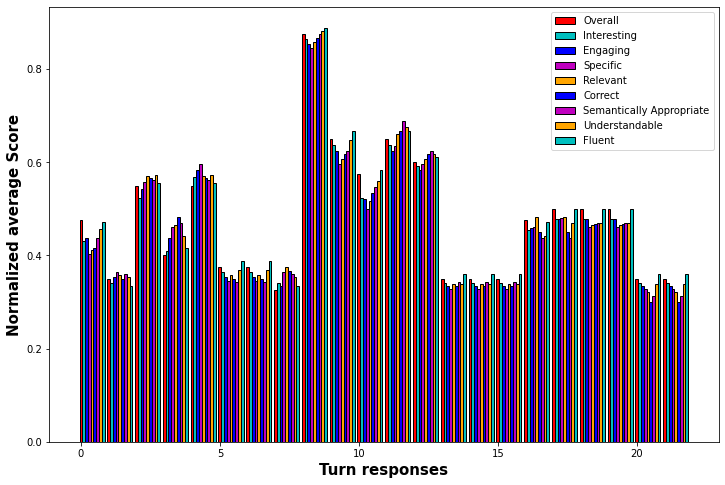

In [143]:
from random import getrandbits, choice
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

score_name = "Overall"
extend__with_bar(0, normalized_scores_overall, score_name, plt, colors, used_colors)
score_name = "Interesting"
extend__with_bar(0.1,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.2,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.3,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.4,normalized_scores_relevant, score_name, plt, colors, used_colors)
score_name = "Correct"
extend__with_bar(0.5,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.6,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.7,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.8,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

### Correlating the human annotations with overall rating

In [157]:
#https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_mean_error_area(scores_x, scores_y):
    x = []
    for key in scores_x:
        x.append(scores_x[key])
    y = []
    for key in scores_y:
        y.append(scores_y[key])
    #print(score_name_x, "&", score_name_y)
    mae = mean_absolute_error(x, y).round(2)
    mse = mean_squared_error(x, y).round(2)
    rmse = mean_squared_error(x, y, squared=False).round(2)
    #print(f"Mean Absolute Error:", mae)
    #print(f"Mean Squared Error:", mse)
    #print(f"Root Mean Squared Error:", rmse)
    return mae, mse, rmse

In [158]:
rows = []
score_name_x = "Overall Human Rating"

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_interesting)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_engaging)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_relevant)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_correct)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_semantic)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_understandable)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, normalized_scores_fluent)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_scores = pd.DataFrame(rows)
df_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_scores.to_csv(file, index=False)

## Correlating automated score with the human ratings

### System likelihood of the agent answers

In [185]:
score_name_x = "System llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.xlsx'):
    df = pd.read_excel(name)
    #print(name)
    js = df.to_json(orient = 'records')
    for turn in json.loads(js):
        if turn['Overall Human Rating']:
            get_score_for_turns(turn, auto_turn_scores, score_name_x)

    break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

22 {4: 0.4048249785, 6: 0.3837550451, 8: 0.2823884716, 10: 0.2232330753, 12: 0.2652660925, 14: 0.1636328896, 16: 0.245290041, 18: 0.2923296631, 20: 0.7834212252, 27: 0.5233162701, 29: 0.4094227708, 31: 0.2430827306, 33: 0.4346051961, 35: 0.5416183869, 37: 0.4919629097, 39: 0.3297088859, 41: 0.5060808897, 43: 0.4478196706, 45: 0.5236826196, 47: 0.4713893618, 49: 0.6426943583, 22: 0}
22 {4: 0.475, 6: 0.35, 8: 0.55, 10: 0.4, 12: 0.55, 14: 0.375, 16: 0.375, 18: 0.32499999999999996, 20: 0.875, 22: 0.65, 27: 0.575, 29: 0.65, 31: 0.6, 33: 0.35, 35: 0.35, 37: 0.35, 39: 0.475, 41: 0.5, 43: 0.5, 45: 0.5, 47: 0.35, 49: 0.35}


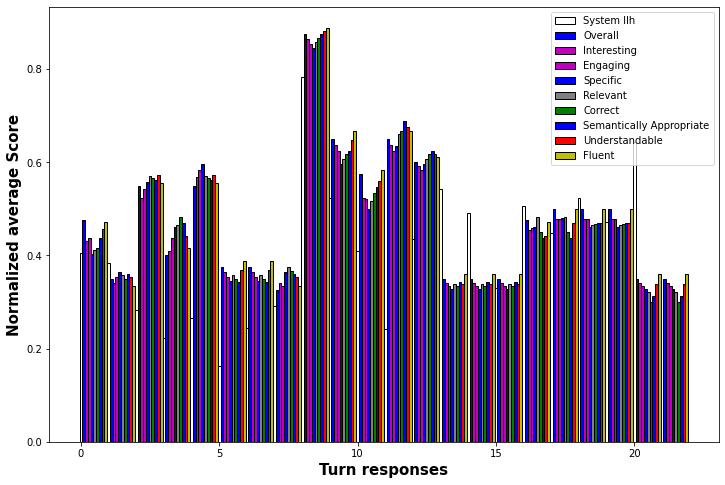

In [186]:
from random import getrandbits, choice
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
used_colors = []

colors=["w"]
extend__with_bar(0, auto_turn_scores, score_name_x, plt, colors, used_colors)
colors=["b","r","g","y","c", "m", "b", "grey", "orange"]


score_name = "Overall"
extend__with_bar(0.1, normalized_scores_overall, score_name, plt, colors, used_colors)
score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.3,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.4,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.5,normalized_scores_relevant, score_name, plt, colors, used_colors)
score_name = "Correct"
extend__with_bar(0.6,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.7,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.8,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.9,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [174]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})



df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

### MLM likelihood of the language model

In [183]:
score_name_x = "MLM llh"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.xlsx'):
    df = pd.read_excel(name)
    #print(name)
    js = df.to_json(orient = 'records')
    for turn in json.loads(js):
        if turn['Overall Human Rating']:
            get_score_for_turns(turn, auto_turn_scores, score_name_x)

    break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)


22 {4: 0.5168273396, 6: 0.6118578464, 8: 0.5774079323, 10: 0.3859520433, 12: 0.3829027694, 14: 0.3626058747, 16: 0.6208761682, 18: 0.5333213196, 20: 0.8158399801, 22: 0.2205545753, 27: 0.7377194762, 29: 0.7587135533, 31: 0.5809098519, 33: 0.6632205801, 35: 0.6948320468, 37: 0.7126809657, 39: 0.6543578207, 41: 0.716771992, 43: 0.6262337595, 45: 0.700227347, 47: 0.7423417313, 49: 0.9519256311}
22 {4: 0.475, 6: 0.35, 8: 0.55, 10: 0.4, 12: 0.55, 14: 0.375, 16: 0.375, 18: 0.32499999999999996, 20: 0.875, 22: 0.65, 27: 0.575, 29: 0.65, 31: 0.6, 33: 0.35, 35: 0.35, 37: 0.35, 39: 0.475, 41: 0.5, 43: 0.5, 45: 0.5, 47: 0.35, 49: 0.35}


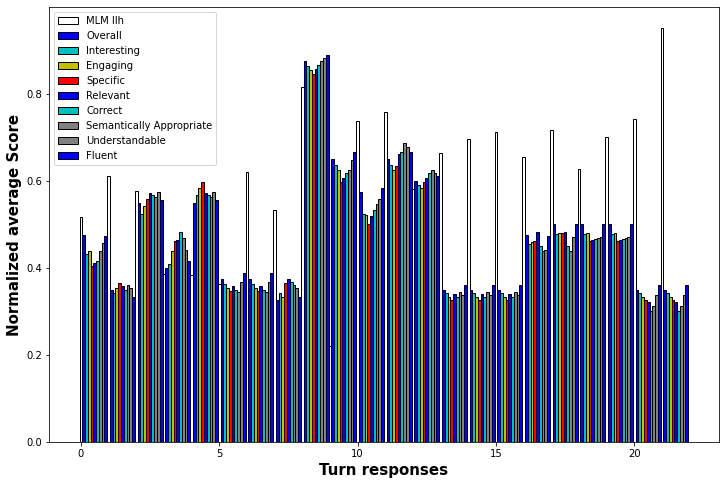

In [184]:
from random import getrandbits, choice
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
used_colors = []

colors=["w"]
extend__with_bar(0, auto_turn_scores, score_name_x, plt, colors, used_colors)
colors=["b","r","g","y","c", "m", "b", "grey", "orange"]

score_name = "Overall"
extend__with_bar(0.1, normalized_scores_overall, score_name, plt, colors, used_colors)
score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.3,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.4,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.5,normalized_scores_relevant, score_name, plt, colors, used_colors)
score_name = "Correct"
extend__with_bar(0.6,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.7,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.8,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.9,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [175]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

22 {4: 0.5168273396, 6: 0.6118578464, 8: 0.5774079323, 10: 0.3859520433, 12: 0.3829027694, 14: 0.3626058747, 16: 0.6208761682, 18: 0.5333213196, 20: 0.8158399801, 22: 0.2205545753, 27: 0.7377194762, 29: 0.7587135533, 31: 0.5809098519, 33: 0.6632205801, 35: 0.6948320468, 37: 0.7126809657, 39: 0.6543578207, 41: 0.716771992, 43: 0.6262337595, 45: 0.700227347, 47: 0.7423417313, 49: 0.9519256311}
22 {4: 0.475, 6: 0.35, 8: 0.55, 10: 0.4, 12: 0.55, 14: 0.375, 16: 0.375, 18: 0.32499999999999996, 20: 0.875, 22: 0.65, 27: 0.575, 29: 0.65, 31: 0.6, 33: 0.35, 35: 0.35, 37: 0.35, 39: 0.475, 41: 0.5, 43: 0.5, 45: 0.5, 47: 0.35, 49: 0.35}


### USR DLcontext

In [187]:
score_name_x = "USR DLcontext"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.xlsx'):
    df = pd.read_excel(name)
    #print(name)
    js = df.to_json(orient = 'records')
    for turn in json.loads(js):
        if turn['Overall Human Rating']:
            get_score_for_turns(turn, auto_turn_scores, score_name_x)

    break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)

22 {4: 0.9459233, 6: 0.99606687, 8: 0.99709404, 10: 0.9973753, 12: 0.99756145, 14: 0.99765503, 16: 0.9976555, 18: 0.9966933, 20: 0.99817526, 22: 0.9972309, 27: 0.9973957, 29: 0.07183881, 31: 0.99690175, 33: 0.99441993, 35: 0.9974916, 37: 0.99744636, 39: 0.9977968, 41: 0.99779767, 43: 0.9977074, 45: 0.99773103, 47: 0.9945315, 49: 0.9974467}
22 {4: 0.475, 6: 0.35, 8: 0.55, 10: 0.4, 12: 0.55, 14: 0.375, 16: 0.375, 18: 0.32499999999999996, 20: 0.875, 22: 0.65, 27: 0.575, 29: 0.65, 31: 0.6, 33: 0.35, 35: 0.35, 37: 0.35, 39: 0.475, 41: 0.5, 43: 0.5, 45: 0.5, 47: 0.35, 49: 0.35}


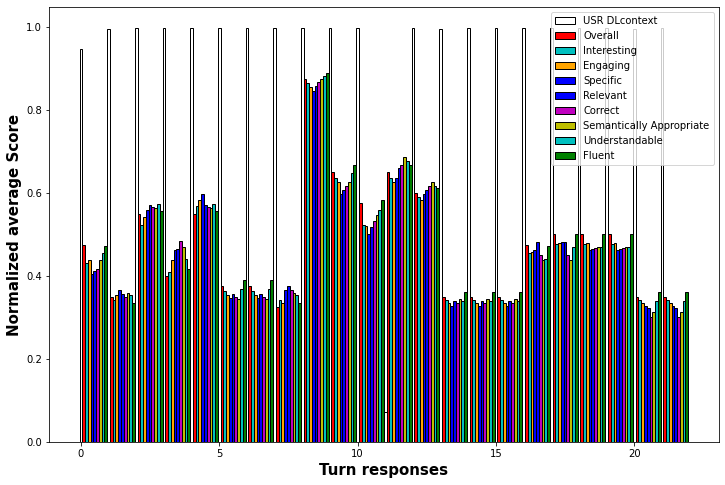

In [188]:
from random import getrandbits, choice
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
used_colors = []

colors=["w"]
extend__with_bar(0, auto_turn_scores, score_name_x, plt, colors, used_colors)
colors=["b","r","g","y","c", "m", "b", "grey", "orange"]

score_name = "Overall"
extend__with_bar(0.1, normalized_scores_overall, score_name, plt, colors, used_colors)
score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.3,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.4,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.5,normalized_scores_relevant, score_name, plt, colors, used_colors)
score_name = "Correct"
extend__with_bar(0.6,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.7,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.8,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.9,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [177]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

22 {4: 0.9459233, 6: 0.99606687, 8: 0.99709404, 10: 0.9973753, 12: 0.99756145, 14: 0.99765503, 16: 0.9976555, 18: 0.9966933, 20: 0.99817526, 22: 0.9972309, 27: 0.9973957, 29: 0.07183881, 31: 0.99690175, 33: 0.99441993, 35: 0.9974916, 37: 0.99744636, 39: 0.9977968, 41: 0.99779767, 43: 0.9977074, 45: 0.99773103, 47: 0.9945315, 49: 0.9974467}
22 {4: 0.475, 6: 0.35, 8: 0.55, 10: 0.4, 12: 0.55, 14: 0.375, 16: 0.375, 18: 0.32499999999999996, 20: 0.875, 22: 0.65, 27: 0.575, 29: 0.65, 31: 0.6, 33: 0.35, 35: 0.35, 37: 0.35, 39: 0.475, 41: 0.5, 43: 0.5, 45: 0.5, 47: 0.35, 49: 0.35}


### USR DLfact

In [ ]:
score_name_x = "USR DLfact"

auto_turn_scores = {}

# We take the turns and scores from the first excel 
# as we assume that the automated data is the same
# for all annotated excel files
for path in basepath.glob('*.xlsx'):
    df = pd.read_excel(name)
    #print(name)
    js = df.to_json(orient = 'records')
    for turn in json.loads(js):
        if turn['Overall Human Rating']:
            get_score_for_turns(turn, auto_turn_scores, score_name_x)

    break ### after the first file we are done

### Check if we have the same numer of keys and make them compatible
for key in normalized_scores_overall:
    if not auto_turn_scores.get(key):
        auto_turn_scores[key]=0
print(len(auto_turn_scores), auto_turn_scores)
print(len(normalized_scores_overall), normalized_scores_overall)



In [ ]:
from random import getrandbits, choice
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
used_colors = []

colors=["w"]
extend__with_bar(0, auto_turn_scores, score_name_x, plt, colors, used_colors)
colors=["b","r","g","y","c", "m", "b", "grey", "orange"]

score_name = "Overall"
extend__with_bar(0.1, normalized_scores_overall, score_name, plt, colors, used_colors)
score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.3,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.4,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.5,normalized_scores_relevant, score_name, plt, colors, used_colors)
score_name = "Correct"
extend__with_bar(0.6,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.7,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.8,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.9,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

In [179]:
rows = []

score_name_y = "Overall Human Rating"
mae, mse, rmse = get_mean_error_area(normalized_scores_overall, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Interesting"
mae, mse, rmse = get_mean_error_area(normalized_scores_interesting, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Engaging"
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Specific"
normalized_scores_specific 
mae, mse, rmse = get_mean_error_area(normalized_scores_engaging, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

score_name_y = "Relevant"
mae, mse, rmse = get_mean_error_area(normalized_scores_relevant,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Correct"
mae, mse, rmse = get_mean_error_area(normalized_scores_correct, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Semantically Appropriate"
mae, mse, rmse = get_mean_error_area(normalized_scores_semantic, auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Understandable" 
mae, mse, rmse = get_mean_error_area(normalized_scores_understandable,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})


score_name_y = "Fluent"
mae, mse, rmse = get_mean_error_area(normalized_scores_fluent,auto_turn_scores)
rows.append({score_name_x: score_name_y, 
             'Mean Absolute Error': mae,
             'Mean Squared Error' : mse,
             'Root Mean Squared Error' : rmse})

df_auto_scores = pd.DataFrame(rows)
df_auto_scores.head()

file = annotation_path+"/"+score_name_x+"_correlation.csv"
df_auto_scores.to_csv(file, index=False)

22 {4: 0.8108158, 6: 0.99697137, 8: 0.9966609, 10: 0.996732, 12: 0.9971691, 14: 0.9972215, 16: 0.9971893, 18: 0.9957021, 20: 0.9971918, 22: 0.99704516, 27: 0.99595106, 29: 0.9629553, 31: 0.99559253, 33: 0.99673134, 35: 0.7678829, 37: 0.9958491, 39: 0.99684817, 41: 0.99604326, 43: 0.99700695, 45: 0.99697953, 47: 0.996926, 49: 0.994947}
22 {4: 0.475, 6: 0.35, 8: 0.55, 10: 0.4, 12: 0.55, 14: 0.375, 16: 0.375, 18: 0.32499999999999996, 20: 0.875, 22: 0.65, 27: 0.575, 29: 0.65, 31: 0.6, 33: 0.35, 35: 0.35, 37: 0.35, 39: 0.475, 41: 0.5, 43: 0.5, 45: 0.5, 47: 0.35, 49: 0.35}


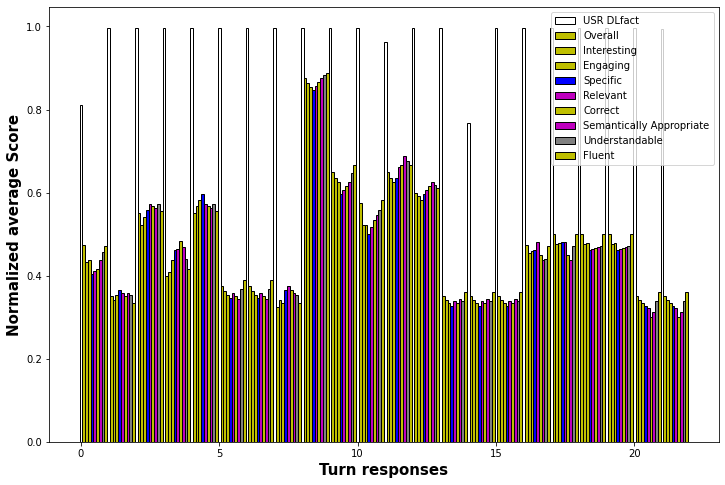

In [180]:
from random import getrandbits, choice
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
colors=["b","r","g","y","c", "m", "b", "w", "grey", "orange"]
used_colors = []

extend__with_bar(0, auto_turn_scores, score_name_x, plt, colors, used_colors)

score_name = "Overall"
extend__with_bar(0.1, normalized_scores_overall, score_name, plt, colors, used_colors)
score_name = "Interesting"
extend__with_bar(0.2,normalized_scores_interesting, score_name, plt, colors, used_colors)
score_name = "Engaging"
extend__with_bar(0.3,normalized_scores_engaging, score_name, plt, colors, used_colors)
score_name = "Specific"
extend__with_bar(0.4,normalized_scores_specific, score_name, plt, colors, used_colors)
score_name = "Relevant"
extend__with_bar(0.5,normalized_scores_relevant, score_name, plt, colors, used_colors)
score_name = "Correct"
extend__with_bar(0.6,normalized_scores_correct, score_name, plt, colors, used_colors)
score_name = "Semantically Appropriate"
extend__with_bar(0.7,normalized_scores_semantic, score_name, plt, colors, used_colors)
score_name = "Understandable"
extend__with_bar(0.8,normalized_scores_understandable, score_name, plt, colors, used_colors)
score_name = "Fluent"
extend__with_bar(0.9,normalized_scores_fluent, score_name, plt, colors, used_colors)

plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Normalized average Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

## End of notebook